# Sentiment Analysis of Austen and Melville

DS 5001 Text as Data

**Purpose:** Use the NRC lexicon to explore sentiment in two novels.

# Set Up

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from IPython.display import display, HTML

In [2]:
sns.set()

## Config

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [4]:
data_prefix = 'austen-melville'

In [5]:
novels_csv = f'{output_dir}/{data_prefix}-CORPUS.csv'
vocab_csv = f'{output_dir}/{data_prefix}-VOCAB2.csv'
lib_csv = f'{output_dir}/{data_prefix}-LIB_LABELS.csv'
bow_csv = f'{output_dir}/{data_prefix}-BOW-CHAPS.csv'

In [6]:
# For TOKENS
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1]
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

In [7]:
salex_csv = f'{data_home}/lexicons/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

# Get Data

In [8]:
TOKENS = pd.read_csv(novels_csv).set_index(OHCO).sort_index()
VOCAB = pd.read_csv(vocab_csv).set_index('term_str').sort_index()
LIB = pd.read_csv(lib_csv).set_index('book_id')[['author','title']].sort_index()
BOW = pd.read_csv(bow_csv).set_index(['book_id','chap_id','term_str']).sort_index()

In [9]:
LIB['author_id'] = LIB.author.str.split(', ').str[0]
LIB['title_short'] = LIB.author_id + ' ' + LIB.index.astype('str') + ': ' + LIB.title.str[:25] 

In [10]:
LIB

author                                              title  \
book_id                                                                        
105          AUSTEN, JANE                                         PERSUASION   
121          AUSTEN, JANE                                   NORTHANGER ABBEY   
141          AUSTEN, JANE                                     MANSFIELD PARK   
158          AUSTEN, JANE                                               EMMA   
161          AUSTEN, JANE                              SENSE AND SENSIBILITY   
946          AUSTEN, JANE                                         LADY SUSAN   
1212         AUSTEN, JANE                            LOVE AND FREINDSHIP SIC   
1342         AUSTEN, JANE                                PRIDE AND PREJUDICE   
1900     MELVILLE, HERMAN                  TYPEE A ROMANCE OF THE SOUTH SEAS   
2701     MELVILLE, HERMAN                             MOBY DICK OR THE WHALE   
4045     MELVILLE, HERMAN                  OMOO ADVENTURES IN THE SOUTH SEAS   
8118     MELVILLE, HERMAN  REDBURN HIS FIRST VOYAGE BEING THE SAILOR BOY ...   
10712    MELVILLE, HERMAN          WHITE JACKET OR THE WORLD ON A MAN OF WAR   
13720    MELVILLE, HERMAN                   MARDI AND A VOYAGE THITHER VOL I   
13721    MELVILLE, HERMAN                  MARDI AND A VOYAGE THITHER VOL II   
15422    MELVILLE, HERMAN             ISRAEL POTTER HIS FIFTY YEARS OF EXILE   
15859    MELVILLE, HERMAN                                   THE PIAZZA TALES   
21816    MELVILLE, HERMAN                  THE CONFIDENCE MAN HIS MASQUERADE   
34970    MELVILLE, HERMAN                          PIERRE OR THE AMBIGUITIES   

        author_id                                title_short  
book_id                                                       
105        AUSTEN                     AUSTEN 105: PERSUASION  
121        AUSTEN               AUSTEN 121: NORTHANGER ABBEY  
141        AUSTEN                 AUSTEN 141: MANSFIELD PARK  
158        AUSTEN                           AUSTEN 158: EMMA  
161        AUSTEN          AUSTEN 161: SENSE AND SENSIBILITY  
946        AUSTEN                     AUSTEN 946: LADY SUSAN  
1212       AUSTEN       AUSTEN 1212: LOVE AND FREINDSHIP SIC  
1342       AUSTEN           AUSTEN 1342: PRIDE AND PREJUDICE  
1900     MELVILLE   MELVILLE 1900: TYPEE A ROMANCE OF THE SO  
2701     MELVILLE      MELVILLE 2701: MOBY DICK OR THE WHALE  
4045     MELVILLE   MELVILLE 4045: OMOO ADVENTURES IN THE SO  
8118     MELVILLE   MELVILLE 8118: REDBURN HIS FIRST VOYAGE   
10712    MELVILLE  MELVILLE 10712: WHITE JACKET OR THE WORLD  
13720    MELVILLE  MELVILLE 13720: MARDI AND A VOYAGE THITHE  
13721    MELVILLE  MELVILLE 13721: MARDI AND A VOYAGE THITHE  
15422    MELVILLE  MELVILLE 15422: ISRAEL POTTER HIS FIFTY Y  
15859    MELVILLE           MELVILLE 15859: THE PIAZZA TALES  
21816    MELVILLE  MELVILLE 21816: THE CONFIDENCE MAN HIS MA  
34970    MELVILLE  MELVILLE 34970: PIERRE OR THE AMBIGUITIES

In [11]:
persuasion = 105
mobydick = 2701

# Get SA Lexicon

In [12]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [13]:
SALEX

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  sentiment  
term_str                                          
abandon            1         0      0         -1  
abandoned          1         0      0         -1  
abandonment        1         1      0         -1  
abduction          1         1      0         -1  
aberration         0         0      0         -1  
...              ...       ...    ...        ...  
young              0         1      0          1  
youth              0         1      0          1  
zeal               0         1      1          1  
zealous            0         0      1          1  
zest               0         0      1          1  

[3688 rows x 11 columns]

# Compute Sentiment

## Join SALEX with VOCAB

In [14]:
V = VOCAB.join(SALEX, how='inner')

In [15]:
V.head()

term_rank   n  n_chars         p          i max_pos_group  \
term_str                                                                 
abandon           6946  20        7  0.000010  16.651555            VB   
abandoned         2555  72        9  0.000035  14.803558            VB   
abandonment       8727  15       11  0.000007  17.066592            NN   
aberration       19827   3       10  0.000001  19.388520            NN   
abhor            10499  11        5  0.000005  17.514051            VB   

            max_pos  n_pos_group                   cat_pos_group  n_pos  ...  \
term_str                                                                 ...   
abandon          VB            3              {'JJ', 'NN', 'VB'}      4  ...   
abandoned       VBN            5  {'VB', 'IN', 'JJ', 'RB', 'NN'}      6  ...   
abandonment      NN            2                    {'JJ', 'NN'}      2  ...   
aberration       NN            1                          {'NN'}      1  ...   
abhor            VB            2                    {'NN', 'VB'}      3  ...   

            anticipation  disgust fear joy negative  positive  sadness  \
term_str                                                                 
abandon                0        0    1   0        1         0        1   
abandoned              0        0    1   0        1         0        1   
abandonment            0        0    1   0        1         0        1   
aberration             0        1    0   0        1         0        0   
abhor                  0        1    1   0        1         0        0   

             surprise  trust  sentiment  
term_str                                 
abandon             0      0         -1  
abandoned           0      0         -1  
abandonment         1      0         -1  
aberration          0      0         -1  
abhor               0      0         -1  

[5 rows x 37 columns]

## Join VOCAB with BOW

In [16]:
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v', how='inner') #.dropna()

In [17]:
B

n        tf     tfidf max_pos  anger  \
book_id chap_id term_str                                           
105     1       admiration  1  0.000381  0.001182      NN      0   
                admire      1  0.000381  0.001539      VB      0   
                advise      1  0.000381  0.001876      VB      0   
                agreeable   2  0.000762  0.002047      JJ      0   
                alarm       1  0.000381  0.001282      NN      0   
...                        ..       ...       ...     ...    ...   
34970   114     warned      1  0.001550  0.008817     VBD      0   
                worse       1  0.001550  0.003924     JJR      0   
                wound       1  0.001550  0.005947      NN      1   
                wreck       1  0.001550  0.008079      NN      1   
                young       2  0.003101  0.003566      JJ      0   

                            anticipation  disgust  fear  joy  sadness  \
book_id chap_id term_str                                                
105     1       admiration             0        0     0    1        0   
                admire                 0        0     0    0        0   
                advise                 0        0     0    0        0   
                agreeable              0        0     0    0        0   
                alarm                  0        0     1    0        0   
...                                  ...      ...   ...  ...      ...   
34970   114     warned                 1        0     1    0        0   
                worse                  0        0     1    0        1   
                wound                  0        0     1    0        1   
                wreck                  0        1     1    0        1   
                young                  1        0     0    1        0   

                            surprise  trust  sentiment  
book_id chap_id term_str                                
105     1       admiration         0      1          1  
                admire             0      1          1  
                advise             0      1          1  
                agreeable          0      1          1  
                alarm              1      0         -1  
...                              ...    ...        ...  
34970   114     warned             1      0          0  
                worse              0      0         -1  
                wound              0      0         -1  
                wreck              1      0         -1  
                young              1      0          1  

[88593 rows x 13 columns]

## Weight Emotions by TFIDF

In [18]:
for col in emo_cols:
    B[col] = B[col] * B.tfidf

In [19]:
B.head()

n        tf     tfidf max_pos  anger  \
book_id chap_id term_str                                           
105     1       admiration  1  0.000381  0.001182      NN    0.0   
                admire      1  0.000381  0.001539      VB    0.0   
                advise      1  0.000381  0.001876      VB    0.0   
                agreeable   2  0.000762  0.002047      JJ    0.0   
                alarm       1  0.000381  0.001282      NN    0.0   

                            anticipation  disgust      fear       joy  \
book_id chap_id term_str                                                
105     1       admiration           0.0      0.0  0.000000  0.001182   
                admire               0.0      0.0  0.000000  0.000000   
                advise               0.0      0.0  0.000000  0.000000   
                agreeable            0.0      0.0  0.000000  0.000000   
                alarm                0.0      0.0  0.001282  0.000000   

                            sadness  surprise     trust  sentiment  
book_id chap_id term_str                                            
105     1       admiration      0.0  0.000000  0.001182   0.001182  
                admire          0.0  0.000000  0.001539   0.001539  
                advise          0.0  0.000000  0.001876   0.001876  
                agreeable       0.0  0.000000  0.002047   0.002047  
                alarm           0.0  0.001282  0.000000  -0.001282

# Explore Emotion Words and POS

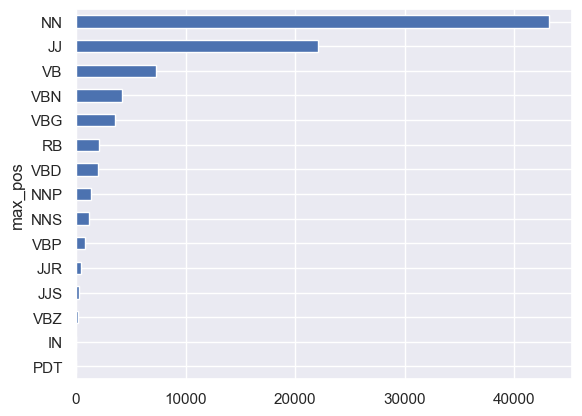

In [20]:
B.max_pos.value_counts().sort_values().plot.barh();

In [21]:
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['book_id','chap_id'])[emo_cols].mean()

In [22]:
EMO_BOOKS.index = LIB.title_short #book_title

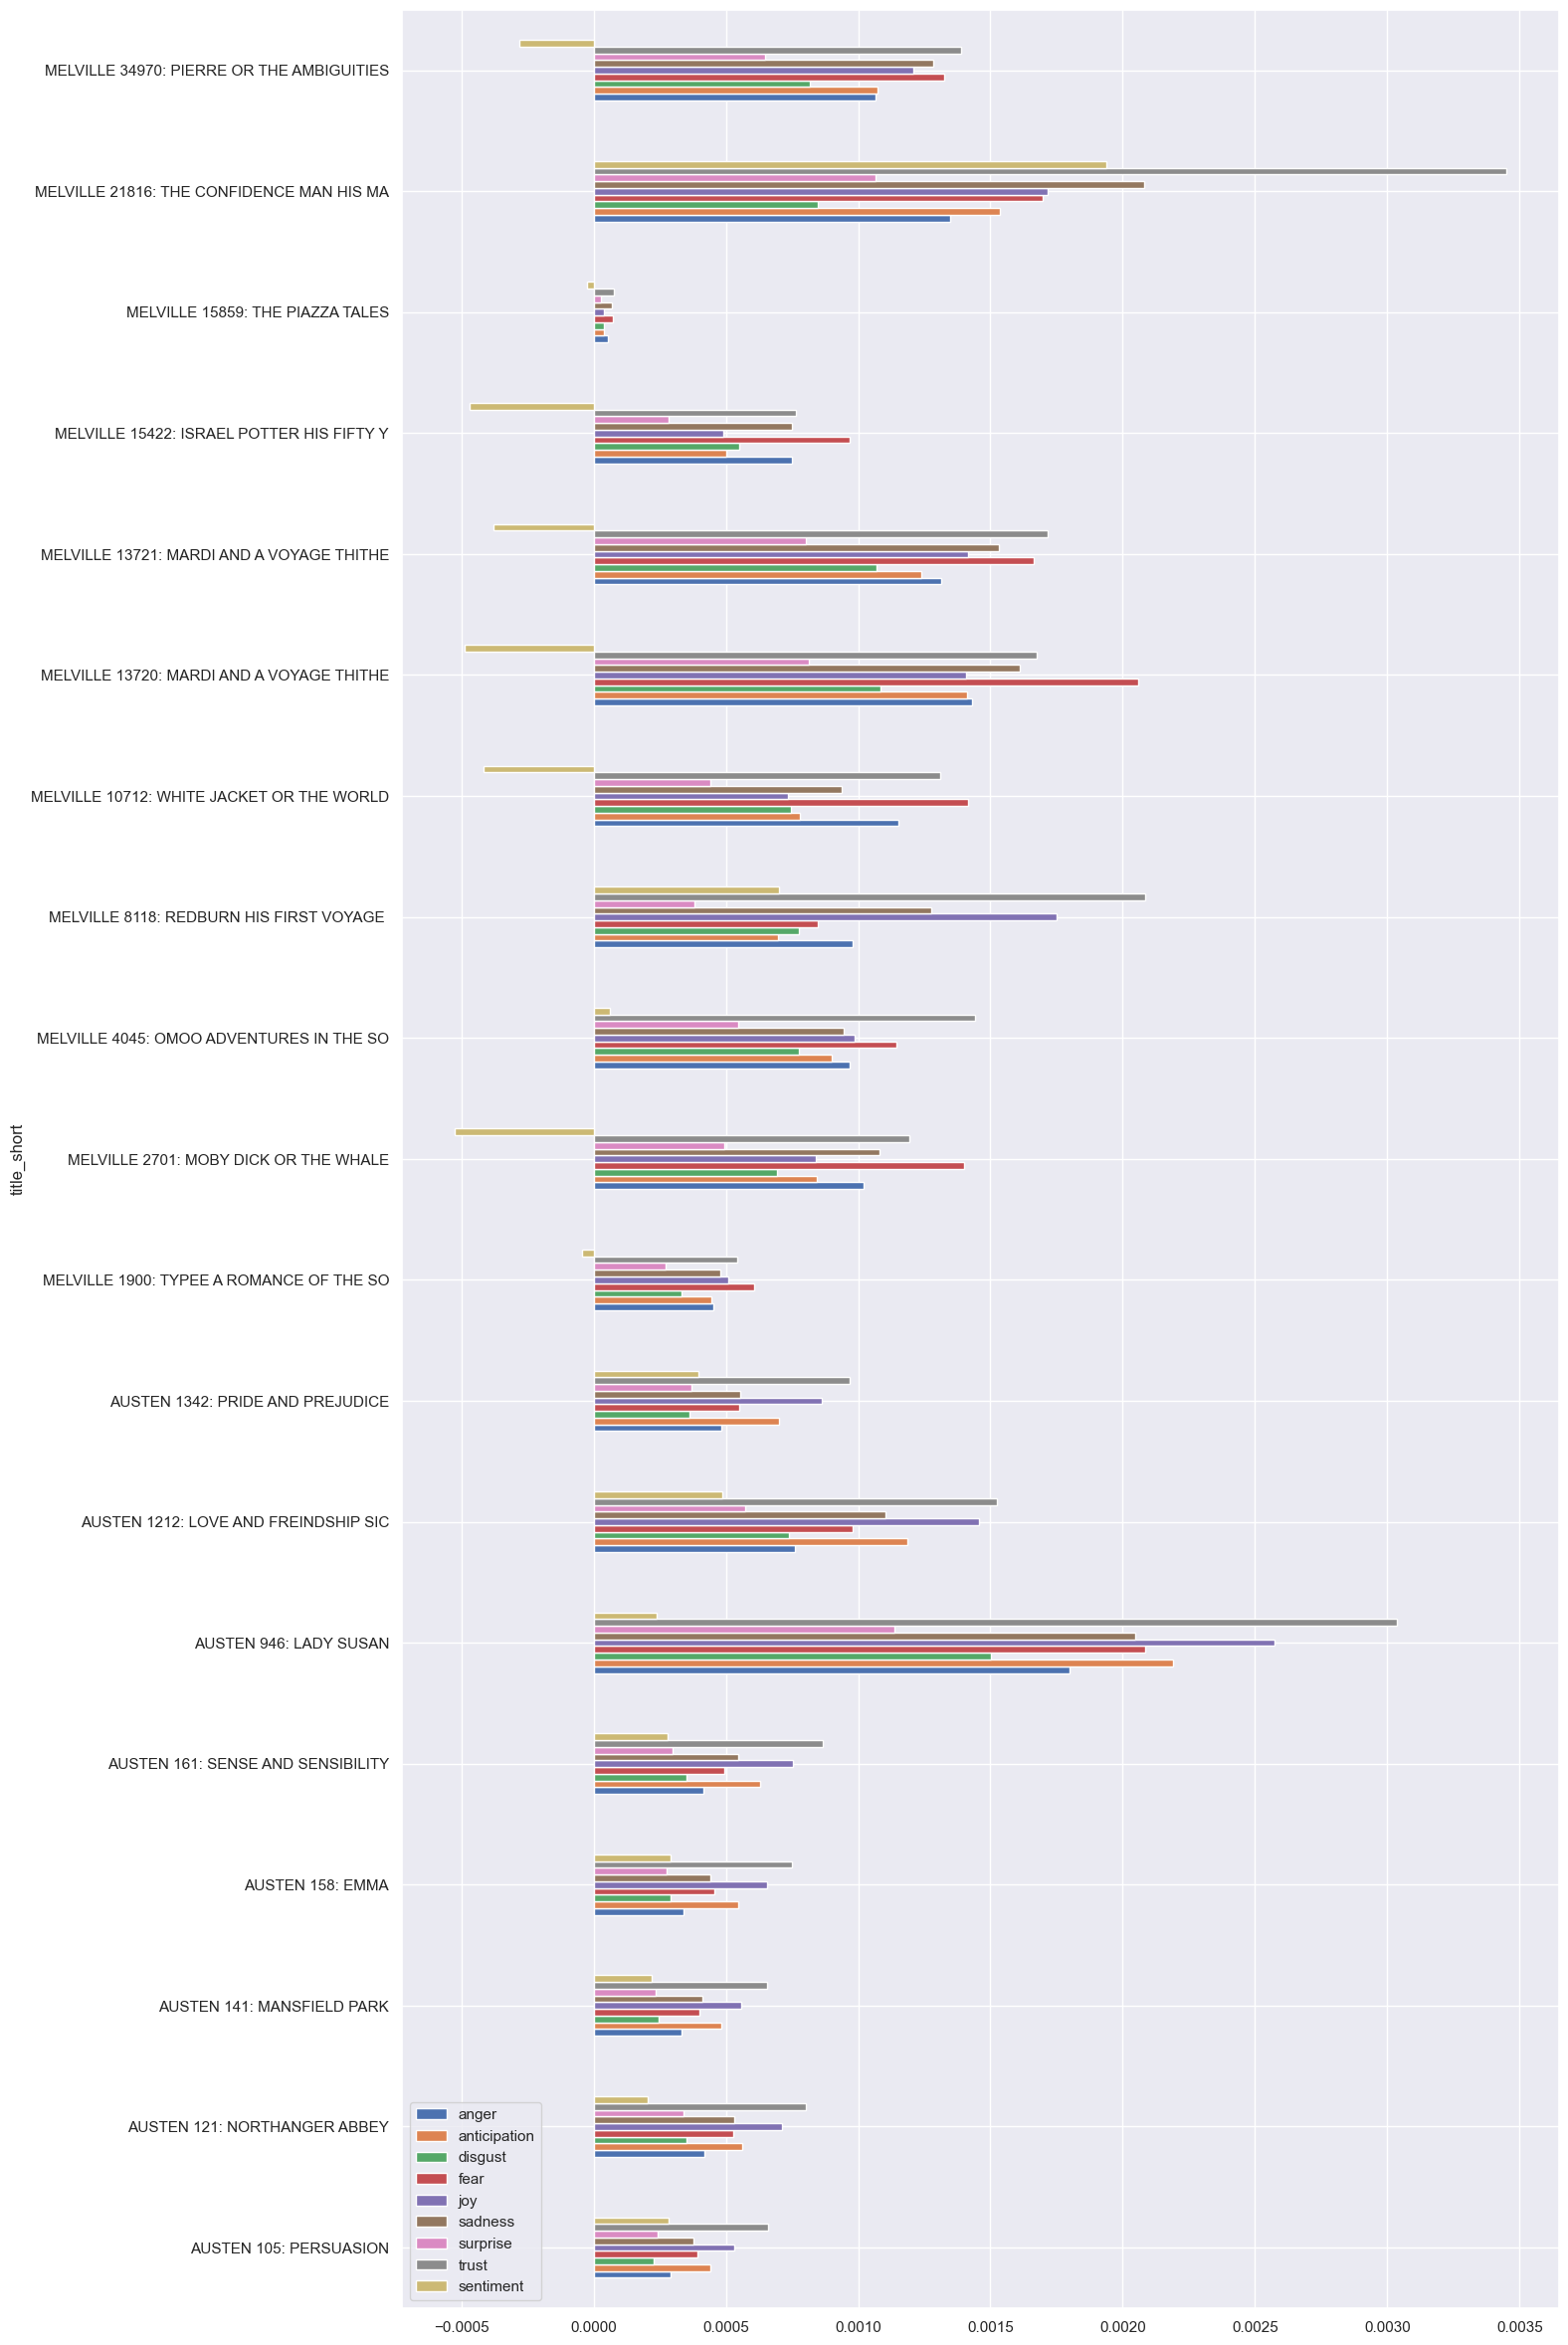

In [23]:
EMO_BOOKS.plot.barh(figsize=(15,30));

In [24]:
px.imshow(EMO_BOOKS.sort_values('sentiment'), 
          width=1200, height=1000, 
          color_continuous_midpoint=0, 
          color_continuous_scale=px.colors.diverging.Spectral)

# Compare Texts: Fear and Joy

In [25]:
PERSUASION = EMO_CHAPS.loc[persuasion].copy()
MOBYDICK = EMO_CHAPS.loc[mobydick].copy()

In [26]:
px.bar(PERSUASION.mean().sort_values(), orientation='h', width=500)

In [27]:
px.bar(MOBYDICK.mean().sort_values(), orientation='h', width=500)

In [28]:
# PERSUASION.mean().sort_values().plot.barh();
# MOBYDICK.mean().sort_values().plot.barh();

# What is Trust?

In [29]:
trust_words = pd.Series(SALEX[SALEX['trust'] == 1].index.tolist())

In [30]:
trust_words.sample(10)

106      brother
235        dance
615      paragon
366     fortress
502    judiciary
154       cogent
692          pry
64       assured
397         good
410        guard
dtype: object

# Mean Sentiment by Chapter

In [31]:
PERSUASION_chaps = EMO_CHAPS.loc[persuasion] 
MOBYDICK_chaps = EMO_CHAPS.loc[mobydick] 

In [32]:
# PERSUASION_chaps.style.background_gradient(cmap='YlGnBu', axis=None)

In [33]:
px.imshow(PERSUASION.T, width=850, height=400, color_continuous_scale=px.colors.diverging.Spectral, color_continuous_midpoint=0.0)

In [34]:
px.bar(PERSUASION.sum(1).to_frame('sum_sent'), width=850)

In [35]:
# MOBYDICK_chaps.style.background_gradient(cmap='YlGnBu', axis=0)

In [36]:
px.imshow(MOBYDICK.T, width=1350, height=400, color_continuous_scale=px.colors.diverging.Spectral, text_auto=False, color_continuous_midpoint=0.0)

In [37]:
px.bar(MOBYDICK.sum(1).to_frame('sum_sent'), width=1350)

In [38]:
' '.join(TOKENS.loc[(mobydick, 125), 'token_str'].to_list())

'THE MAIN TOP SAIL YARD. TASHTEGO PASSING NEW LASHINGS AROUND IT. "Um, um, um. Stop that thunder! Plenty too much thunder up here. What\'s the use of thunder? Um, um, um. We don\'t want thunder; we want rum; give us a glass of rum. Um, um, um!"'

In [39]:
PERSUASION_chaps_thin = EMO_CHAPS.loc[persuasion].stack().to_frame('valence').reset_index().rename(columns={'level_1':'emo'})
MOBYDICK_chaps_thin = EMO_CHAPS.loc[mobydick].stack().to_frame('valence').reset_index().rename(columns={'level_1':'emo'})

In [40]:
px.line(PERSUASION_chaps_thin, x='chap_id', y='valence', color='emo', height=500, title="Persuasion")

In [41]:
px.line(MOBYDICK_chaps_thin, x='chap_id', y='valence', color='emo', height=500, title="Moby Dick")

# Cose Read Sentiment in Texts

## Combine VOCAB + SALEX with TOKENS

We need to do this to reconstruct the sentences, which are lost in the BOW representation.

In [42]:
T = TOKENS.join(V, on='term_str').fillna(0)

In [43]:
T.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0               ('Sir', 'NNP')  NNP   
                                  1            ('Walter', 'NNP')  NNP   
                                  2           ('Elliot,', 'NNP')  NNP   
                                  3                 ('of', 'IN')   IN   
                                  4          ('Kellynch', 'NNP')  NNP   

                                            token_str  term_str pos_group  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0               Sir       sir        NN   
                                  1            Walter    walter        NN   
                                  2           Elliot,    elliot        NN   
                                  3                of        of        IN   
                                  4          Kellynch  kellynch        NN   

                                             term_rank       n  n_chars  \
book_id chap_id para_num sent_num token_num                               
105     1       1        0        0              135.0  1798.0      3.0   
                                  1                0.0     0.0      0.0   
                                  2                0.0     0.0      0.0   
                                  3                0.0     0.0      0.0   
                                  4                0.0     0.0      0.0   

                                                    p          i  ...  \
book_id chap_id para_num sent_num token_num                       ...   
105     1       1        0        0          0.000873  10.161306  ...   
                                  1          0.000000   0.000000  ...   
                                  2          0.000000   0.000000  ...   
                                  3          0.000000   0.000000  ...   
                                  4          0.000000   0.000000  ...   

                                            anticipation disgust  fear  joy  \
book_id chap_id para_num sent_num token_num                                   
105     1       1        0        0                  0.0     0.0   0.0  0.0   
                                  1                  0.0     0.0   0.0  0.0   
                                  2                  0.0     0.0   0.0  0.0   
                                  3                  0.0     0.0   0.0  0.0   
                                  4                  0.0     0.0   0.0  0.0   

                                             negative positive  sadness  \
book_id chap_id para_num sent_num token_num                               
105     1       1        0        0               0.0      1.0      0.0   
                                  1               0.0      0.0      0.0   
                                  2               0.0      0.0      0.0   
                                  3               0.0      0.0      0.0   
                                  4               0.0      0.0      0.0   

                                            surprise trust sentiment  
book_id chap_id para_num sent_num token_num                           
105     1       1        0        0              0.0   1.0       1.0  
                                  1              0.0   0.0       0.0  
                                  2              0.0   0.0       0.0  
                                  3              0.0   0.0       0.0  
                                  4              0.0   0.0       0.0  

[5 rows x 42 columns]

## Wrap Tokens in HTML tags

In [44]:
PERSUASION2 = T.loc[persuasion].copy()
MOBYDICK2 = T.loc[mobydick].copy()

In [45]:
emo = 'sentiment'

In [46]:
PERSUASION2['html'] = PERSUASION2.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.term_str), 1)
MOBYDICK2['html'] =  MOBYDICK2.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.term_str), 1)

In [47]:
PERSUASION2[['html']].sample(10)

html
chap_id para_num sent_num token_num                                       
16      12       6        5                 <span class='sent0'>the</span>
23      15       5        41                <span class='sent0'>set</span>
3       18       1        80           <span class='sent-1'>hearing</span>
21      18       0        3                 <span class='sent0'>the</span>
2       3        1        7                  <span class='sent0'>it</span>
4       10       3        34                 <span class='sent0'>of</span>
11      4        1        1          <span class='sent0'>usefulness</span>
10      13       0        43                <span class='sent0'>the</span>
11      9        3        124        <span class='sent0'>resembling</span>
20      17       4        0                 <span class='sent0'>she</span>

In [48]:
# PERSUASION2.head()

## Compute Mean Sentiment per Sentence

In [49]:
PERSUASION_sents = PERSUASION2.groupby(SENTS[1:])[emo_cols].mean()
MOBYDICK_sents = MOBYDICK2.groupby(SENTS[1:])[emo_cols].mean()

In [50]:
PERSUASION_sents

anger  anticipation   disgust      fear  \
chap_id para_num sent_num                                               
1       1        0         0.039216      0.009804  0.019608  0.039216   
                 1         0.000000      0.000000  0.000000  0.000000   
        2        0         0.000000      0.000000  0.000000  0.000000   
        3        0         0.000000      0.000000  0.000000  0.000000   
                 1         0.000000      0.000000  0.000000  0.000000   
...                             ...           ...       ...       ...   
24      12       3         0.000000      0.000000  0.000000  0.000000   
                 4         0.000000      0.038462  0.000000  0.076923   
                 5         0.000000      0.055556  0.000000  0.027778   
        14       0         0.000000      0.000000  0.000000  0.000000   
        18       0         0.000000      0.000000  0.000000  0.000000   

                                joy   sadness  surprise     trust  sentiment  
chap_id para_num sent_num                                                     
1       1        0         0.049020  0.039216  0.000000  0.049020     0.0000  
                 1         0.000000  0.000000  0.000000  0.000000     0.0000  
        2        0         0.000000  0.000000  0.000000  0.000000     0.0000  
        3        0         0.062500  0.000000  0.000000  0.000000     0.0625  
                 1         0.000000  0.000000  0.000000  0.000000     0.0000  
...                             ...       ...       ...       ...        ...  
24      12       3         0.125000  0.000000  0.000000  0.062500     0.1250  
                 4         0.076923  0.000000  0.000000  0.000000     0.0000  
                 5         0.027778  0.027778  0.027778  0.027778     0.0000  
        14       0         0.000000  0.000000  0.000000  0.000000     0.0000  
        18       0         0.000000  0.000000  0.000000  0.000000     0.0000  

[3722 rows x 9 columns]

## Display HTML for each Sentence

In [51]:
PERSUASION_sents['sent_str'] = PERSUASION2.groupby(SENTS[1:]).term_str.apply(lambda x: ' '.join(map(str, x))) # For VADER below
PERSUASION_sents['html_str'] = PERSUASION2.groupby(SENTS[1:]).html.apply(lambda x: ' '.join(map(str, x)))

In [52]:
MOBYDICK_sents['sent_str'] = MOBYDICK2.groupby(SENTS[1:]).term_str.apply(lambda x: ' '.join(map(str, x))) # For VADER below
MOBYDICK_sents['html_str'] = MOBYDICK2.groupby(SENTS[1:]).html.apply(lambda x: ' '.join(map(str, x)))

In [53]:
def sample_sentences(df):
    rows = []
    for idx in df.sample(10).index:

        valence = round(df.loc[idx, emo], 4)     
        t = 0
        if valence > t: color = '#ccffcc'
        elif valence < t: color = '#ffcccc'
        else: color = '#f2f2f2'
        z=0
        rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
        <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
        </tr>""".format(color, valence, df.loc[idx, 'html_str'], idx))

    display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
    display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

In [54]:
sample_sentences(PERSUASION_sents)

In [55]:
sample_sentences(MOBYDICK_sents)

# Try VADER

In [56]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

Apply analyzer to each sentence.

In [57]:
PERSUASION_vader_cols = PERSUASION_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
PERSUASION_vader = PERSUASION_sents.join(PERSUASION_vader_cols)

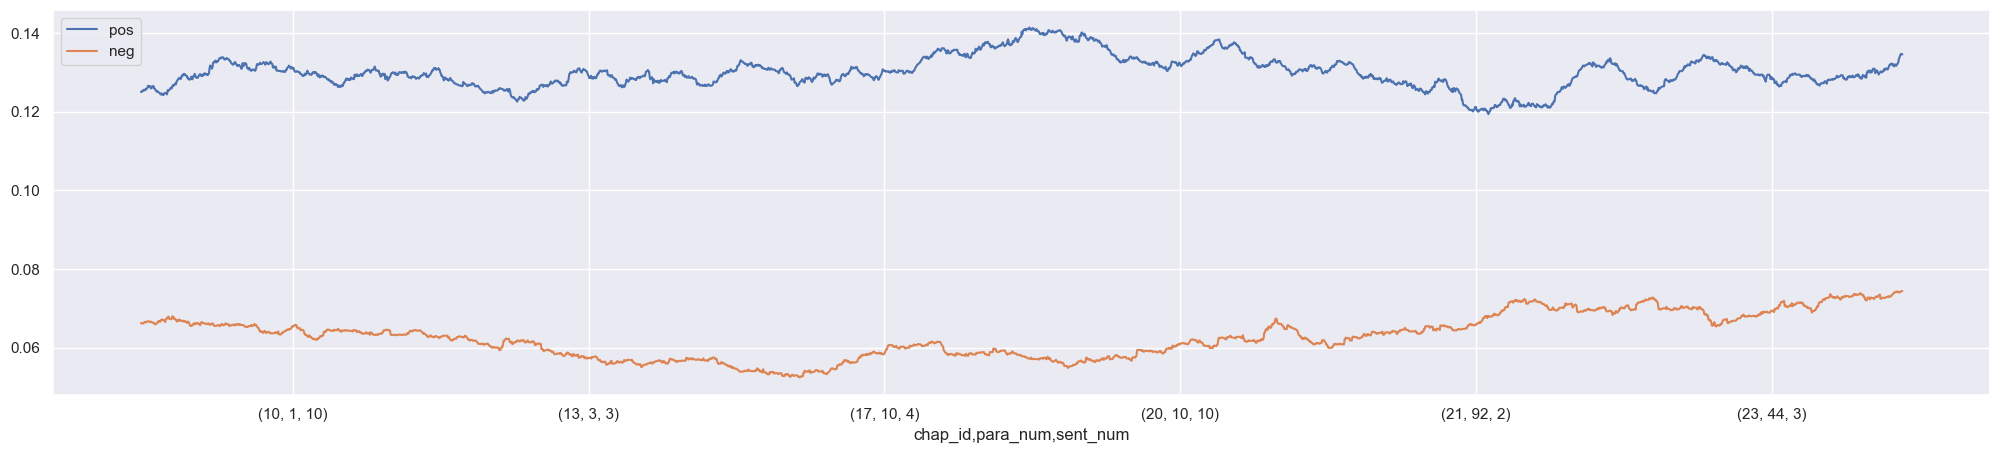

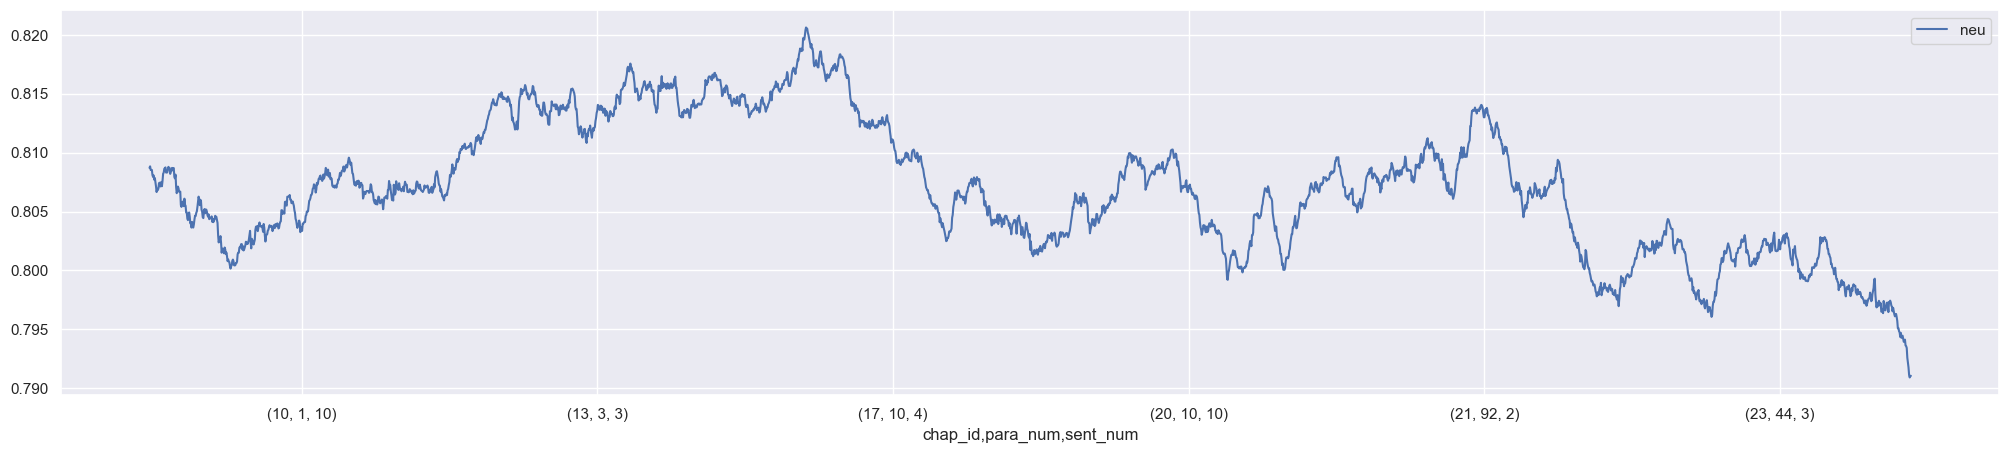

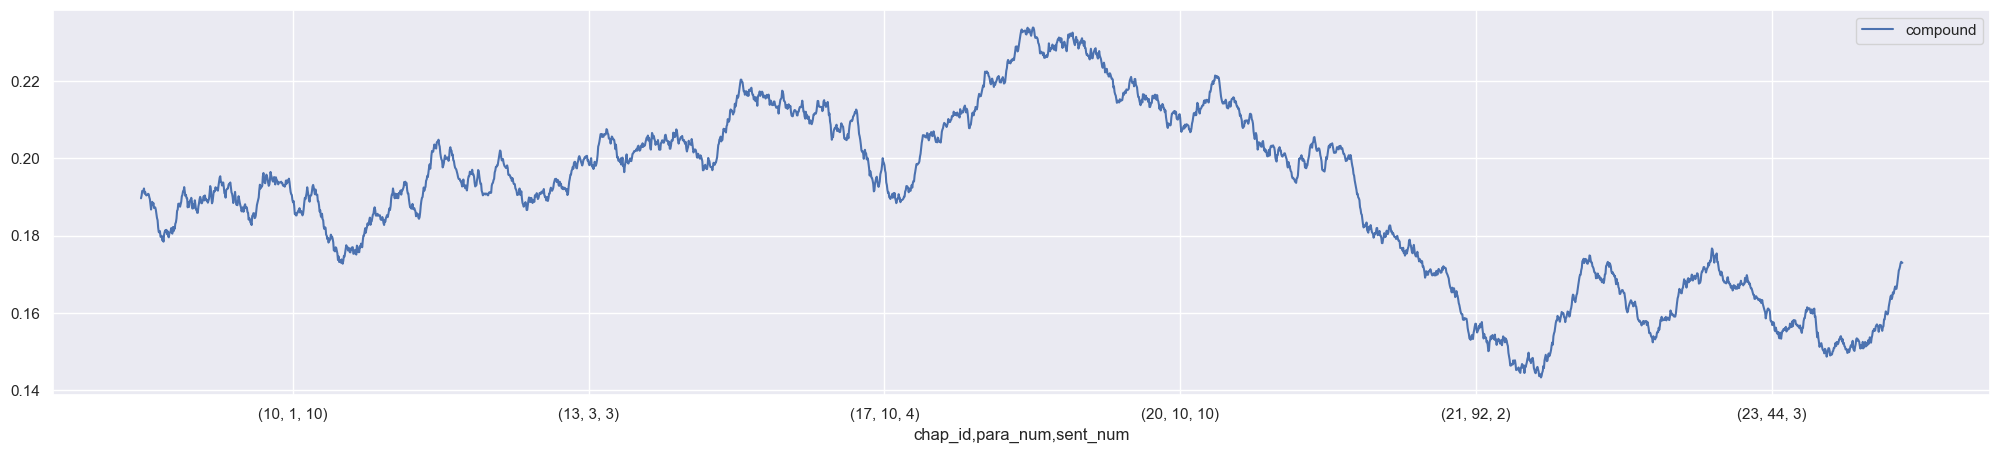

In [58]:
w = int(PERSUASION_vader.shape[0] / 5)
PERSUASION_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));
PERSUASION_vader[['neu']].rolling(w).mean().plot(figsize=(25,5));
PERSUASION_vader[['compound']].rolling(w).mean().plot(figsize=(25,5));

In [59]:
MOBYDICK_vader_cols = MOBYDICK_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
MOBYDICK_vader = MOBYDICK_sents.join(MOBYDICK_vader_cols)

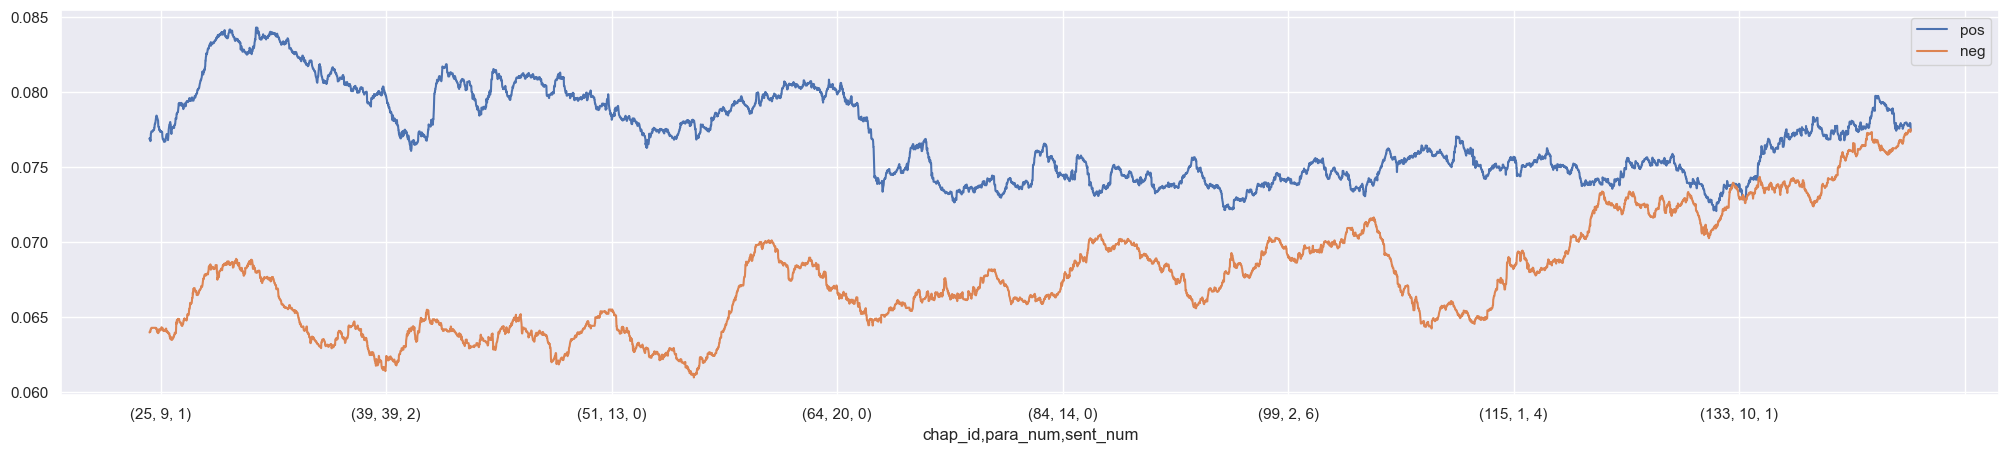

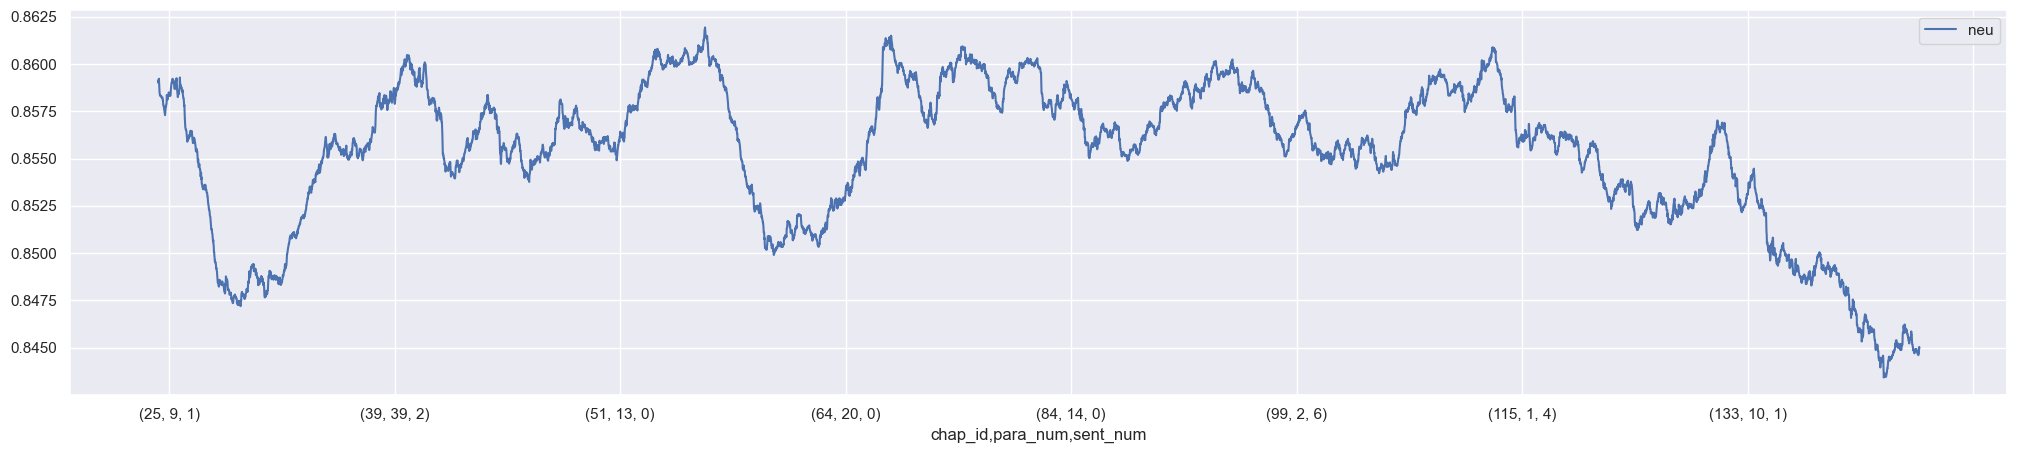

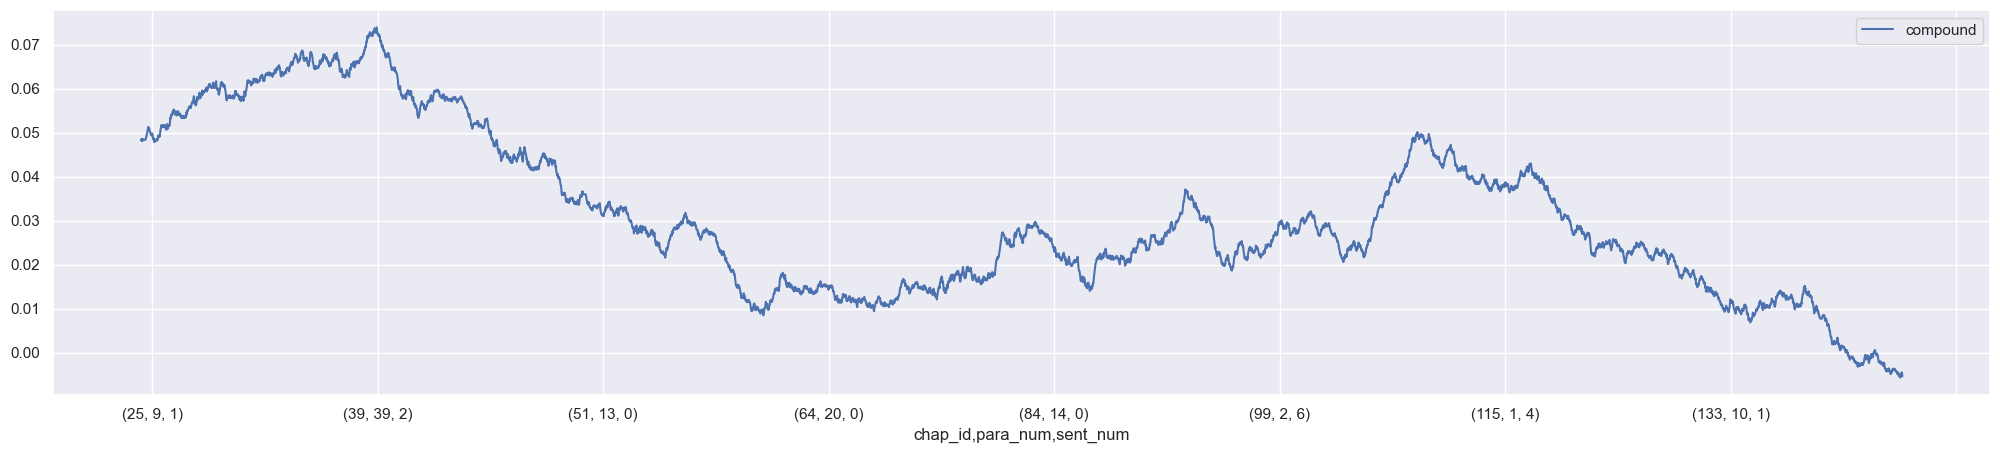

In [60]:
w = int(MOBYDICK_vader.shape[0] / 5)
MOBYDICK_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));
MOBYDICK_vader[['neu']].rolling(w).mean().plot(figsize=(25,5));
MOBYDICK_vader[['compound']].rolling(w).mean().plot(figsize=(25,5));

# Emo Space

In [61]:
import sys; sys.path.append("../lib/")
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

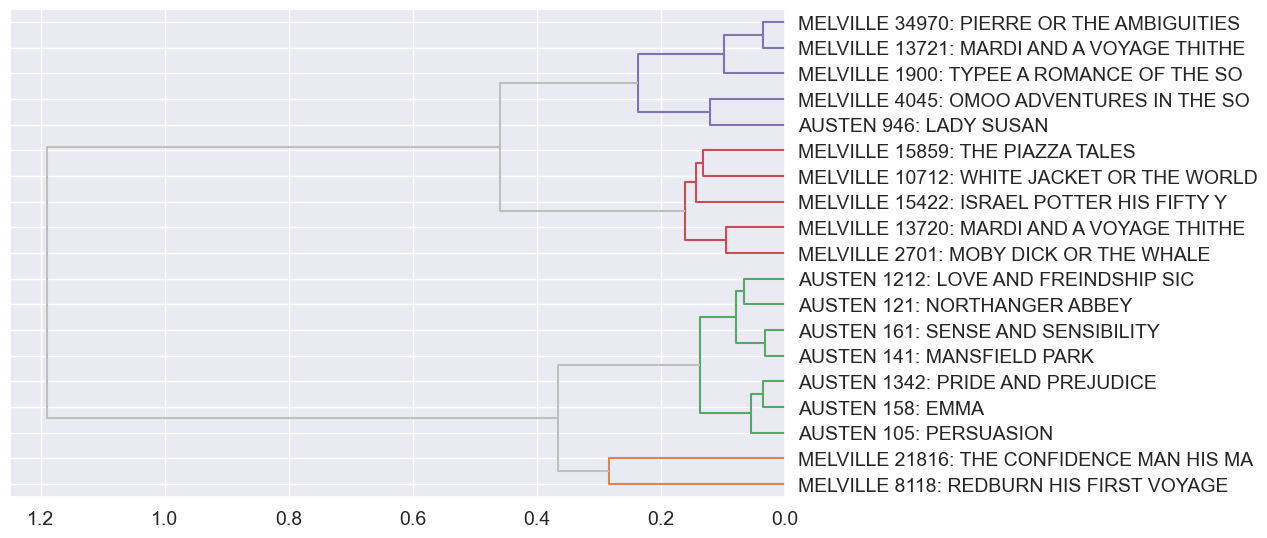

In [62]:
emo_tree = HAC(EMO_BOOKS)
emo_tree.color_thresh=.35
emo_tree.plot()

<Figure size 640x480 with 0 Axes>

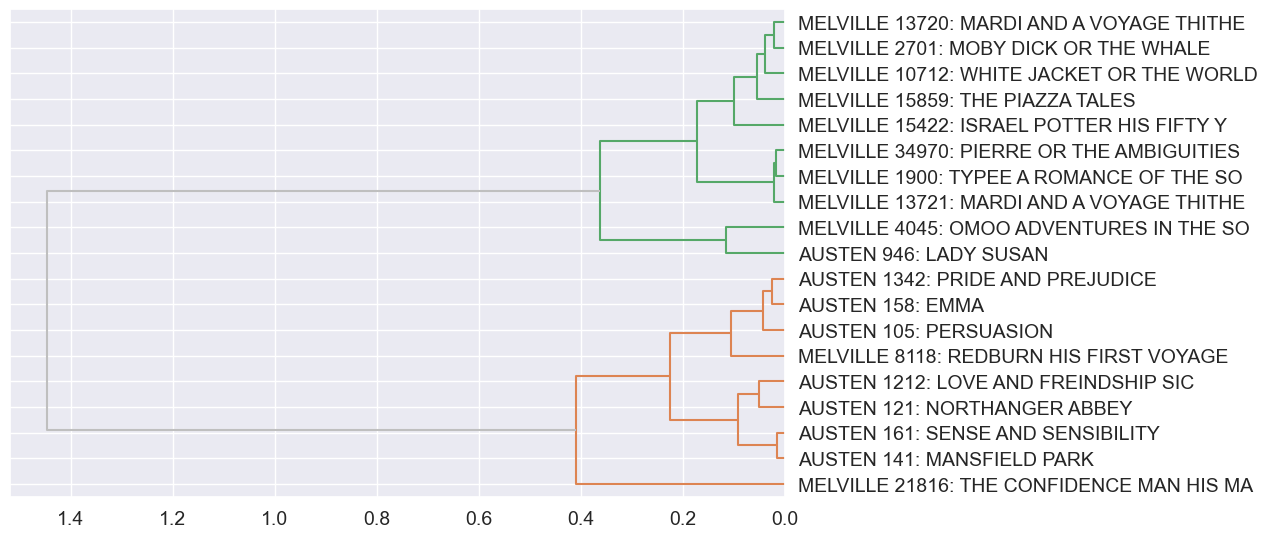

In [63]:
emo_tree = HAC(EMO_BOOKS.T.corr())
emo_tree.color_thresh=.5
emo_tree.plot()

# Save

In [64]:
B.to_csv(f"{output_dir}/{data_prefix}-SENTBOW.csv")